# 03 — Suitability Scoring for Impervious Surfaces

In this notebook we take the engineered impervious-surface dataset from Notebook 02
(`impervious_features.gpkg`) and transform it into a preliminary **greening suitability index**.

This scoring framework serves as a first prototype aligned with the aims of the *Grey to Green*
initiative: identifying which impervious surfaces in Göteborg may offer higher potential for
conversion into green or blue infrastructure.

## Objectives

1. Load the feature-rich impervious dataset.
2. Select meaningful features for suitability: 
   - Distance to green
   - Distance to water
   - Distance to major roads
   - Compactness and geometric constraints
   - Distance to city centre
3. Normalise these features into 0–1 scales.
4. Combine them into a preliminary suitability index.
5. Classify polygons into High, Medium, and Low suitability groups.
6. Export a geospatial dataset ready for mapping and ML exploration.

This notebook focuses on transparency and interpretability, rather than optimised weights.
Weights can later be refined through stakeholder workshops, empirical modelling, or ML classifiers.



In [1]:
import pathlib
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt

from shapely.geometry import Point

PROJECT_DIR = pathlib.Path("..").resolve()

DATA_RAW = PROJECT_DIR / "data" / "raw"
DATA_PROCESSED = PROJECT_DIR / "data" / "processed"
OUTPUTS = PROJECT_DIR / "outputs"
MAPS_DIR = OUTPUTS / "maps"

PROJECT_DIR, DATA_RAW, DATA_PROCESSED, MAPS_DIR

(WindowsPath('D:/Programming/geo-projects/impervious-to-green-gbg'),
 WindowsPath('D:/Programming/geo-projects/impervious-to-green-gbg/data/raw'),
 WindowsPath('D:/Programming/geo-projects/impervious-to-green-gbg/data/processed'),
 WindowsPath('D:/Programming/geo-projects/impervious-to-green-gbg/outputs/maps'))

In [2]:
# Path to the impervious features created in Notebook 02
features_path = DATA_PROCESSED / "impervious_features.gpkg"

impervious = gpd.read_file(features_path)

# Quick structure check
impervious.head(), impervious.shape, impervious.crs


(   source        area_m2    area_ha  perimeter_m  compactness  bbox_ratio  \
 0  ua2018    3732.744159   0.373274   277.693739     1.643971    0.836845   
 1  ua2018    5257.072176   0.525707   514.365502     4.004883    0.976495   
 2  ua2018    3540.900042   0.354090   308.162464     2.134204    0.415632   
 3  ua2018   23052.689464   2.305269  1128.530042     4.396376    0.202775   
 4  ua2018  107752.964736  10.775296  4361.349415    14.047617    0.846141   
 
    dist_to_green_m  dist_to_water_m  dist_to_city_center_m  \
 0       153.472944      3510.938743           15786.136616   
 1       168.673464      3443.009132           15695.898183   
 2       326.246045      3438.818296           15510.553562   
 3       217.247102      3226.591225           15216.656950   
 4       216.436698      2942.794147           15172.776695   
 
    dist_to_major_road_m  index_right     NAMN  STADSOMRAD  \
 0           9836.450600            1  Sydväst         3.0   
 1           9822.506185  

In [3]:
impervious[[
    "area_ha",
    "compactness",
    "bbox_ratio",
    "dist_to_green_m",
    "dist_to_water_m",
    "dist_to_major_road_m",
    "dist_to_city_center_m",
    "NAMN",
    "STADSOMRAD"
]].describe(include="all")


,area_ha,compactness,bbox_ratio,dist_to_green_m,dist_to_water_m,dist_to_major_road_m,dist_to_city_center_m,NAMN,STADSOMRAD
count,113232.000000,113232.000000,113232.000000,113232.000000,113232.000000,113232.000000,113232.000000,113232,113232.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hisingen,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,40439,NaN
mean,0.265619,5.692008,1.318359,16815.571046,15390.903683,19191.981637,6417.113261,NaN,2.805885
std,11.605530,410.166002,1.333464,5814.667293,5370.093917,5970.777973,4041.366150,NaN,1.067683
min,0.000057,1.000315,0.025224,55.715476,76.909641,128.625440,0.000000,NaN,1.000000
25%,0.020547,1.274448,0.619959,13218.159647,11896.990160,15317.987606,3175.434517,NaN,2.000000
50%,0.040903,1.789586,0.994863,16610.308513,14835.172213,18635.050490,5420.852765,NaN,3.000000
75%,0.103939,3.210306,1.570436,20636.194917,19126.121197,22633.661734,9153.310257,NaN,4.000000


## 1.Suitability scoring framework

In this notebook we transform the engineered impervious dataset into a preliminary
**greening suitability index**. The aim is not to produce a final policy tool, but a
transparent, explainable prototype that can later be refined together with planners and domain experts.

### 1. Feature selection

We organise the available features into three dimensions:

1. **Environmental suitability**
   - `dist_to_green_m`: distance to nearest existing green area
   - `dist_to_water_m`: distance to nearest water body

   Intuition: it is generally easier and more ecologically meaningful to extend or connect
   to existing green/blue structures than to create completely isolated pockets.

2. **Spatial suitability**
   - `dist_to_major_road_m`: distance to major (buffered) roads
   - `dist_to_city_center_m`: distance to a central reference point (Gustav Adolfs Torg)

   Intuition: surfaces very close to heavy traffic are less attractive for many greening
   functions (comfort, air quality, noise). Surfaces further from the city centre may have
   fewer space constraints and lower land-use competition.

3. **Morphological suitability**
   - `area_ha`: size of the impervious surface
   - `compactness`: perimeter² / (4π·area), where higher values mean more irregular or elongated shapes

   Intuition: larger, more compact surfaces are often easier to convert into coherent green
   interventions than tiny fragments or extremely irregular slivers.

### 2. Normalisation strategy

To combine these heterogeneous features, we convert each into a 0–1 score:

- We use a **capped min–max scaling**:
  - Distances and areas are capped at a high percentile (e.g. 95th or 99th) to reduce the
    influence of extreme outliers.
  - Values are then scaled to the [0, 1] interval.

- We **invert** scores where “closeness” is good:
  - For `dist_to_green_m` and `dist_to_water_m`, being *closer* is better.
    After scaling we use:  
    **proximity score = 1 − scaled_distance**

- For `dist_to_major_road_m` and `dist_to_city_center_m`, we start with the simple assumption
  that being *further* away is better (at least in this prototype), so we use the scaled
  distance directly as a positive contribution.

- For `compactness`, lower values (more compact shapes) are better, so we invert the scaled value:
  **shape score = 1 − scaled_compactness**

### 3. Composite scores

We then define three composite subscores:

- **Environmental score**  
  Average of the green and water proximity scores.

- **Spatial score**  
  Average of the distance-to-road and distance-to-centre scores.

- **Morphology score**  
  Average of the area score and (inverted) compactness score.

Finally, the **overall suitability index** is the simple average of the three subscores:

\\[
\text{Suitability} = \frac{\text{Environmental} + \text{Spatial} + \text{Morphology}}{3}
\\]

All components are in the range [0, 1], so the final index is also in [0, 1].

### 4. Classification

For interpretation and mapping we split the continuous suitability index into three classes:

- **Low suitability** – bottom third (0–33rd percentile)
- **Medium suitability** – middle third (33–66th percentile)
- **High suitability** – top third (66–100th percentile)

These thresholds are purely statistical and can be adjusted later
(e.g. using expert-defined cut-offs or natural breaks).


In [4]:
def scale_0_1_capped(series, upper_q=0.95):
    """
    Min-max scale a positive series to [0, 1], capping values at a chosen upper quantile.
    - Values above the quantile are set to the quantile (reduces outlier influence).
    - Assumes non-negative input.
    """
    s = series.copy().astype(float)
    cap = s.quantile(upper_q)
    s_clipped = s.clip(lower=0, upper=cap)

    s_min = s_clipped.min()
    s_max = s_clipped.max()

    # Avoid division by zero if all values are identical
    if s_max == s_min:
        return pd.Series(0.5, index=series.index)

    return (s_clipped - s_min) / (s_max - s_min)


### 1.1. Distance Based Scaling

In [5]:
# Distances where "closer is better" → we invert after scaling
green_scaled = scale_0_1_capped(impervious["dist_to_green_m"], upper_q=0.95)
water_scaled = scale_0_1_capped(impervious["dist_to_water_m"], upper_q=0.95)

impervious["score_green_proximity"] = 1 - green_scaled
impervious["score_water_proximity"] = 1 - water_scaled

# Distances where "further is better" (prototype assumption)
road_scaled = scale_0_1_capped(impervious["dist_to_major_road_m"], upper_q=0.95)
center_scaled = scale_0_1_capped(impervious["dist_to_city_center_m"], upper_q=0.95)

impervious["score_far_from_road"] = road_scaled
impervious["score_far_from_center"] = center_scaled

### 1.2 Morphology Scaling

In [7]:
# Area: larger surfaces are more interesting for greening (cap at 99th percentile)
area_scaled = scale_0_1_capped(impervious["area_ha"], upper_q=0.99)
impervious["score_area"] = area_scaled

# Compactness: lower compactness (more compact shapes) is better, so we invert
# First scale, then invert
compactness_scaled = scale_0_1_capped(impervious["compactness"], upper_q=0.95)
impervious["score_shape_compact"] = 1 - compactness_scaled

In [8]:
impervious[[
    "score_green_proximity",
    "score_water_proximity",
    "score_far_from_road",
    "score_far_from_center",
    "score_area",
    "score_shape_compact",
]].describe()


,score_green_proximity,score_water_proximity,score_far_from_road,score_far_from_center,score_area,score_shape_compact
count,113232.000000,113232.000000,113232.000000,113232.000000,113232.000000,113232.000000
mean,0.381001,0.382209,0.628788,0.443089,0.052838,0.797924
std,0.208953,0.210637,0.189408,0.270737,0.132518,0.265176
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.235771,0.227226,0.504116,0.221702,0.007302,0.750792
50%,0.385267,0.401298,0.614205,0.378472,0.014556,0.910999
75%,0.511230,0.520492,0.746913,0.639063,0.037021,0.969088
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


## 2. Compute subscores & Overall Suitability

In [9]:
# Environmental subscore
impervious["env_score"] = impervious[[
    "score_green_proximity",
    "score_water_proximity",
]].mean(axis=1)

# Spatial subscore 
impervious["spatial_score"] = impervious[[
    "score_far_from_road",
    "score_far_from_center",
]].mean(axis=1)

# Morphology subscore
impervious["morph_score"] = impervious[[
    "score_area",
    "score_shape_compact",
]].mean(axis=1)

# Overall suitability index 
impervious["suitability_index"] = impervious[[
    "env_score",
    "spatial_score",
    "morph_score",
]].mean(axis=1)

impervious[["env_score", "spatial_score", "morph_score", "suitability_index"]].describe()


,env_score,spatial_score,morph_score,suitability_index
count,113232.000000,113232.000000,113232.000000,113232.000000
mean,0.381605,0.535938,0.425381,0.447641
std,0.209044,0.169658,0.125379,0.064985
min,0.000000,0.130871,0.000124,0.263195
25%,0.232441,0.405909,0.396860,0.417059
50%,0.392235,0.480164,0.467204,0.442178
75%,0.516345,0.630402,0.491540,0.472797
max,0.994543,1.000000,0.991921,0.848426


In [10]:
# Compute tertile thresholds
q_low, q_high = np.quantile(impervious["suitability_index"], [1/3, 2/3])

q_low, q_high

(np.float64(0.42596635299693886), np.float64(0.4607036018386733))

In [11]:
def classify_suitability(value, low, high):
    if value <= low:
        return "low"
    elif value <= high:
        return "medium"
    else:
        return "high"

impervious["suitability_class"] = impervious["suitability_index"].apply(
    lambda v: classify_suitability(v, q_low, q_high)
)

impervious["suitability_class"].value_counts(normalize=True)


suitability_class
high      0.333333
medium    0.333333
low       0.333333
Name: proportion, dtype: float64

## 3. Suitability Map

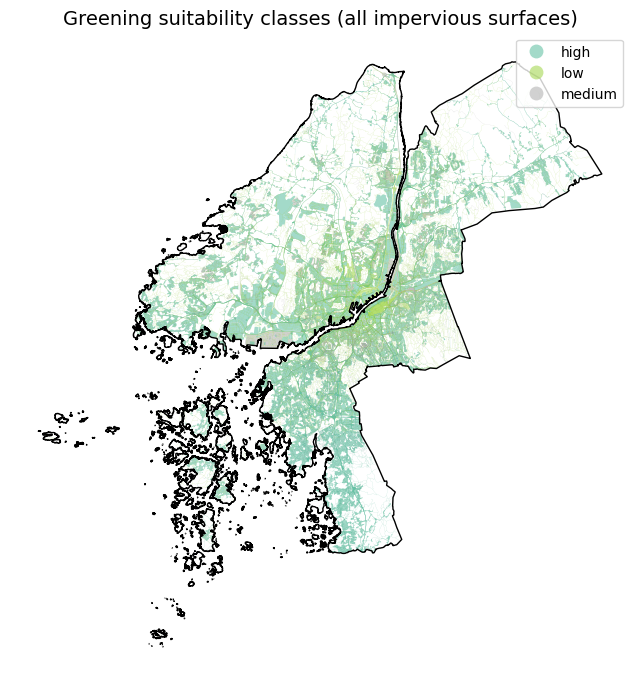

In [ ]:
# Static
 
fig, ax = plt.subplots(figsize=(8, 12))

boundary_path = DATA_PROCESSED / "gothenburg_boundary.gpkg"
gothenburg_boundary = gpd.read_file(boundary_path)

# Plot suitability classes for ALL impervious polygons
impervious.plot(
    column="suitability_class",
    categorical=True,
    legend=True,
    ax=ax,
    cmap="Set2",
    alpha=0.6,
    linewidth=0
)

# Overlay the boundary for context
gothenburg_boundary.boundary.plot(ax=ax, color="black", linewidth=1)

ax.set_title("Greening suitability classes (all impervious surfaces)", fontsize=14)
ax.set_axis_off()

plt.show()


In [15]:
# Interactive

import folium

# Filter to UA2018 impervious polygons
ua_imp = impervious[impervious["source"] == "ua2018"].copy()

# Reproject to WGS84 for web mapping
ua_imp_wgs = ua_imp.to_crs(epsg=4326)

# Colour mapping for suitability classes
suitability_colors = {
    "low": "#f03b20",     # red
    "medium": "#feb24c",  # orange
    "high": "#31a354",    # green
}

def suitability_style(feature):
    cls = feature["properties"].get("suitability_class", "medium")
    color = suitability_colors.get(cls, "#cccccc")
    return {
        "color": color,
        "weight": 0,
        "fillOpacity": 0.6,
    }

# Map centre roughly on Göteborg
m = folium.Map(
    location=[57.7089, 11.9746],
    zoom_start=10,
    tiles="CartoDB positron"
)

folium.GeoJson(
    ua_imp_wgs,
    name="UA2018 impervious (suitability)",
    style_function=suitability_style,
    tooltip=folium.GeoJsonTooltip(
        fields=["suitability_class", "suitability_index", "area_ha", "NAMN"],
        aliases=["Suitability", "Index", "Area (ha)", "Stadsområde"],
        sticky=False
    ),
).add_to(m)

folium.LayerControl().add_to(m)

# Save interactive map
MAPS_DIR.mkdir(parents=True, exist_ok=True)
suit_map_path = MAPS_DIR / "suitability_ua2018_interactive.html"
m.save(str(suit_map_path))

print("Saved interactive map to:", suit_map_path)


Saved interactive map to: D:\Programming\geo-projects\impervious-to-green-gbg\outputs\maps\suitability_ua2018_interactive.html


In [19]:
# Export suitability results

DATA_PROCESSED.mkdir(parents=True, exist_ok=True)
MAPS_DIR.mkdir(parents=True, exist_ok=True)

# Full impervious dataset with all features + scores
scores_path = DATA_PROCESSED / "impervious_with_scores.gpkg"
impervious.to_file(scores_path, driver="GPKG")
print("Saved full feature+score layer to:", scores_path)

# UA2018-only subset with scores (lighter and useful for mapping)
ua_suit = impervious[impervious["source"] == "ua2018"].copy()
ua_suit_path = DATA_PROCESSED / "ua2018_impervious_with_scores.gpkg"
ua_suit.to_file(ua_suit_path, driver="GPKG")
print("Saved UA2018-only suitability layer to:", ua_suit_path)

# GeoJSON for web / external tools: UA2018 only to keep size reasonable
ua_suit_geojson = DATA_PROCESSED / "ua2018_impervious_with_scores.geojson"
ua_suit.to_file(ua_suit_geojson, driver="GeoJSON")
print("Saved UA2018-only suitability GeoJSON to:", ua_suit_geojson)


Saved full feature+score layer to: D:\Programming\geo-projects\impervious-to-green-gbg\data\processed\impervious_with_scores.gpkg
Saved UA2018-only suitability layer to: D:\Programming\geo-projects\impervious-to-green-gbg\data\processed\ua2018_impervious_with_scores.gpkg
Saved UA2018-only suitability GeoJSON to: D:\Programming\geo-projects\impervious-to-green-gbg\data\processed\ua2018_impervious_with_scores.geojson


# Summary — Greening Suitability Scoring

In this notebook we transformed the engineered impervious-surface features from Notebook 02
into a first prototype of a **greening suitability index** for Göteborg.

## 1. Input

We started from:

- `data/processed/impervious_features.gpkg`  
  containing all impervious polygons (UA2018 + OSM roads + OSM parking) with:
  - geometric features (area, perimeter, compactness, bbox_ratio)
  - distance features (to green, water, major roads, city centre)
  - contextual attributes (stadsområde name and code)

All data were already in SWEREF99 12 00 (EPSG:3007), so distances and areas are in metres
and square metres.

## 2. Feature dimensions

We organised the features into three dimensions, matching the detailed framework:

- **Environmental suitability**  
  Distance to nearest green and water bodies.

- **Spatial suitability**  
  Distance to major roads and distance to the city centre.

- **Morphological suitability**  
  Area of the polygon and compactness (more compact shapes scoring better).

These reflect ecological connectivity, spatial conditions, and physical feasibility.

---

## 3. Normalisation

We used **capped min–max scaling** (95–99th percentiles) to control outliers and rescale all features to [0, 1].

Inversions are applied where being *closer* is beneficial (green, water) or where lower values are preferred (compactness). Other features (e.g. distance to major roads) use the scaled value directly.

---

## 4. Composite scores

From these per-feature scores we defined three subscores:

- **Environmental score**  
  Average of green and water proximity scores.

- **Spatial score**  
  Average of “far from major road” and “far from city centre” scores.

- **Morphology score**  
  Average of area score and (inverted) compactness score.

The **overall suitability index** is the mean of the three subscores, remaining within [0, 1].

## 5. Classification and mapping

For interpretability we converted the continuous index into three classes using tertiles:

- **Low suitability** — bottom third (0–33rd percentile)  
- **Medium suitability** — middle third (33–66th percentile)  
- **High suitability** — top third (66–100th percentile)

We produced static maps and an interactive Folium map:

- A city-wide overview of suitability classes for **all** impervious surfaces.
- A more focused interactive map for **UA2018 impervious polygons**, showing suitability class,
  index value, area, and stadsområde on hover.

These visualisations provide an intuitive first impression of where “grey” surfaces might be
more promising candidates for future greening.

## 6. Outputs

This notebook produced the following key outputs:

- `data/processed/impervious_with_scores.gpkg`  
  – all impervious polygons with full feature set and suitability scores.

- `data/processed/ua2018_impervious_with_scores.gpkg`  
  – UA2018-only impervious polygons with scores (lighter and suited for mapping/communication).

- `data/processed/ua2018_impervious_with_scores.geojson`  
  – GeoJSON version for web use and external tools.

- `outputs/maps/suitability_ua2018_interactive.html`  
  – interactive Folium map of UA2018 impervious surfaces coloured by suitability class.

## 7. Role in the overall project

This suitability scoring framework is a **first, transparent prototype** rather than a final
policy instrument. It demonstrates how geospatial and morphological features can be combined
into an interpretable index aligned with the *Grey to Green* ambitions: identifying grey
surfaces where greening interventions may be most promising.

In later notebooks, this scoring can be:

- compared with historical change patterns (e.g. green → artificial)  
- refined via stakeholder input or domain-specific weights  
- used as a target or explanatory variable in simple machine-learning experiments.
